In [17]:
import pandas as pd
import numpy as np
import random
import scipy
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
%matplotlib inline

random.seed(42)

 <a id='eda'></a>
### Первичный анализ данных

Прочитаем данные из файла `ab_datas.csv`. Сохраним их в датафрейм `df`. 

Прочитаем данные и посмотрим на первые 5 строк:

In [2]:
df = pd.read_csv('ab_datas.csv')

df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


Посмотрим, сколько посетителей заходило на сайт (количество строк в нашем датафрейме)

In [3]:
#количество посетителей всего

n_rows = df.shape[0]
print("Число строк: {}".format(n_rows))

Число строк: 294478


Сколько уникальных пользователей (уникальных `user_id`) в датасете?

In [4]:
user_total = df.nunique()['user_id']
print("Число уникальных пользователей : {}".format(user_total))

Число уникальных пользователей : 290584


Посетителей из контрольной `control` группы должны были направлять на страницу в старом дизайне  `old_page` , пользователей из тестовой группы `treatment` - на страницу в новом дизайне `new_page`. Проверим, были ли ошибки при направлении.

In [5]:
mismatch_1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print("Из тестовой группы неверно направлены {}".format(len(mismatch_1)) + " пользователей")

mismatch_2 = df.query("group == 'control' and landing_page == 'new_page'")
print("Из контрольной группы неверно направлены  {}".format(len(mismatch_2)) + " пользователей")


Из тестовой группы неверно направлены 1965 пользователей
Из контрольной группы неверно направлены  1928 пользователей


Выясним, есть ли в данных пропуски.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
 5   revenue       294478 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 13.5+ MB


Из сообщений следует, что пропущенных значений нет.

Средний чек по всем посетителям

In [7]:
rev_all=df['revenue'].mean()
print("Средний чек по всем посетителям: {}".format(rev_all))

Средний чек по всем посетителям: 101.9677191504968


In [8]:
# можно и так:
sum(df['revenue'].values)/n_rows

101.9677191504968

Посмотрим на описательную статистику нашего датасета (воспользуемся функцией  `describe`).

In [9]:
df_grp = df.groupby('group')
df_grp['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,147202.0,87.431896,102.424926,0.0,0.0,0.0,250.0,250.0
treatment,147276.0,116.496238,102.732069,0.0,0.0,100.0,250.0,250.0


Как видим, средний чек покупки в группе "treatment" существенно выше, чем в группе control. То есть можно предположить, что новый дизайн сайта привел к нужным нам результатам. Но еще необходимо убедиться, что эти отличия статистически значимы.

In [10]:
#объем тестовой группы
n_rows_treat = len(df[df['group'] == 'treatment'])

#объем контрольной группы
n_rows_contr = n_rows-n_rows_treat

print("Соотношение размеров тестовой и контрольной групп: {}".format(n_rows_treat/n_rows_contr))

print("Вероятность, что новый пользователь будет направлен на версию со старым дизайном: {}".format(n_rows_treat/n_rows))
print("Вероятность, что новый пользователь будет направлен на версию с новым дизайном: {}".format(n_rows_contr/n_rows))


Соотношение размеров тестовой и контрольной групп: 1.0005027105609978
Вероятность, что новый пользователь будет направлен на версию со старым дизайном: 0.5001256460584492
Вероятность, что новый пользователь будет направлен на версию с новым дизайном: 0.49987435394155083


### Проверка гипотезы

<a id='si1'></a>
#### Формулировка рабочей гипотезы

Рабочая гипотеза в нашем случае может быть сформулирована так: "Чек покупки пользователей, перенаправленных на новый сайт, больше чем чек покупки пользователей старого сайта".

<a id='si2'></a>
#### Формальное описание нулевой и альтернативной гипотез

$H_{0}$ : $\theta_{new} = \theta_{old}$ 

$H_{1}$ : $\theta_{new} \neq \theta_{old}$ 

<a id='si1'></a>
#### Выбор подходящего статистического теста (статистического критерия)

Истинные значения $\theta_{new}$ и $\theta_{old}$ мы найти не можем, но мы можем их сравнить. В этом помогут те самые две теоремы.






На основании Закона больших чисел мы можем оценить средние значения случайных величин $\theta_{new}$ и $\theta_{old}$ на  генеральных совокупностях по их средним значениям на наших больших выборках.

На основании Центральной предельной теоремы средние значения распределены нормально при больших объемах выборок.

Чтобы выбрать для проверки наших гипотез подходящий статистический критерий, уясним задачу. Нам нужно выяснить, случайно или значимо отличаются средние значения, т.е. средний чек посетителей в контрольной и тестовой выборках.

Для проведения вычислений будем использовать t-критерий.

#### Проведение вычислений. $T$-test.

In [47]:
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(df.query("group == 'treatment'")['revenue'],
                                                              df.query("group == 'control'")['revenue'],
                                                              alternative="two-sided",
                                                              usevar='unequal')

In [48]:
print("T-статистика={},  p_value={}".format(t_score, p_value))

T-статистика=76.87767795975593,  p_value=0.0


Полученный уровень значимости 0 говорит о том, что с вероятностью 100% гипотеза о равенстве средних двух выборок должна быть отвергнута. То есть переход на новый дизайн, действительно, повлиял на средний чек покупки.

## bootstrap  
Сделаем стат выводы при помощи bootstrap-а

In [53]:
df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


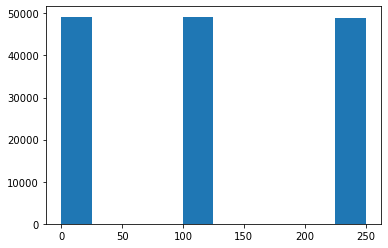

In [54]:
plt.hist(df.loc[df['group']=='treatment', 'revenue']);

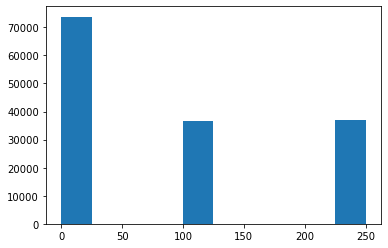

In [55]:
plt.hist(df.loc[df['group']=='control', 'revenue']);

In [56]:
b = df.loc[df['group']=='treatment', 'revenue'].values
a = df.loc[df['group']=='control', 'revenue'].values

In [57]:
from sklearn.utils import resample

a_means = []
b_means = []

for i in range(10000):
    a_boot = resample(a, replace=True, n_samples=len(a))
    b_boot = resample(b, replace=True, n_samples=len(b))
    
    a_means.append(a_boot.mean())
    b_means.append(b_boot.mean())
    
a_means = np.array(a_means)
b_means = np.array(b_means)

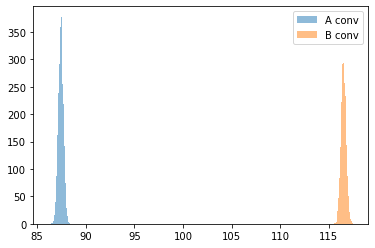

In [58]:
plt.hist(a_means, label='A conv', alpha=0.5, bins=100)
plt.hist(b_means, label='B conv', alpha=0.5, bins=100)

plt.legend()
plt.show()

In [59]:
# доверительный интервал
np.percentile(a_means, 2.5), np.percentile(a_means, 97.5)

(86.90743841795629, 87.9468349614815)

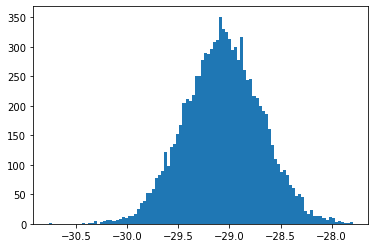

In [60]:
plt.hist(a_means - b_means, bins=100)
plt.show()

In [61]:
# сделаем оценку на p_value
dff = a_means - b_means

len(dff[dff>=0])/len(dff)

0.0

По всем графикам отчетливо видно, насколько сильно различаются средние чеки у двух групп пользователей (пришле